### Overview

### Loss

In [2]:
# sklearn tests
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(noise=0.2, random_state=42,n_samples=1000)
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

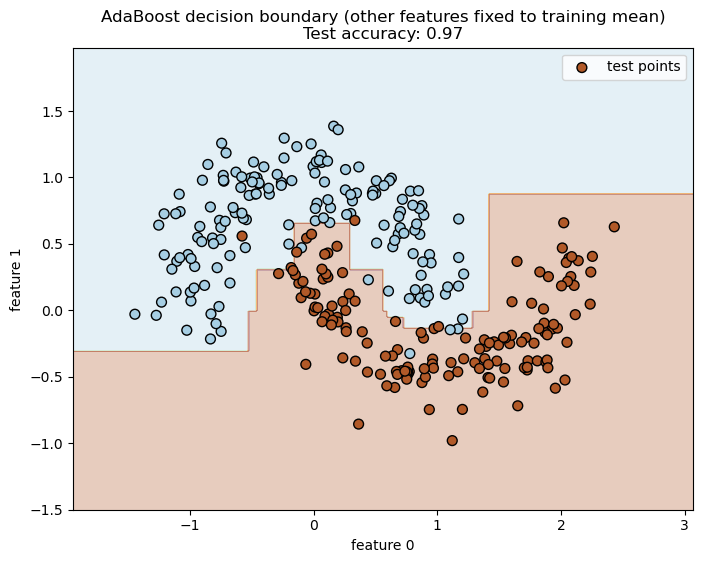

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# fit classifier
clf.fit(X_train, y_train)

# choose two features to visualize (0 and 1)
x_idx, y_idx = 0, 1

# mesh for plotting (cover both train and test ranges)
xmin = np.min(np.r_[X_train[:, x_idx], X_test[:, x_idx]]) - 0.5
xmax = np.max(np.r_[X_train[:, x_idx], X_test[:, x_idx]]) + 0.5
ymin = np.min(np.r_[X_train[:, y_idx], X_test[:, y_idx]]) - 0.5
ymax = np.max(np.r_[X_train[:, y_idx], X_test[:, y_idx]]) + 0.5
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 300), np.linspace(ymin, ymax, 300))

# build full-dimensional grid points by fixing other features at their training mean
mean_features = np.mean(X_train, axis=0)
grid2d = np.c_[xx.ravel(), yy.ravel()]
n_pts = grid2d.shape[0]
full_grid = np.tile(mean_features, (n_pts, 1))
full_grid[:, x_idx] = grid2d[:, 0]
full_grid[:, y_idx] = grid2d[:, 1]

# predict on the grid and plot
Z = clf.predict(full_grid).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X_test[:, x_idx], X_test[:, y_idx], c=y_test, cmap=plt.cm.Paired, edgecolor='k', s=50, label='test points')
plt.xlabel(f'feature {x_idx}')
plt.ylabel(f'feature {y_idx}')
plt.title(f'AdaBoost decision boundary (other features fixed to training mean)\nTest accuracy: {clf.score(X_test, y_test):.2f}')
plt.legend()
plt.show()

### Stencil

In [4]:
import copy
import math

def node_score_error(prob):
    '''
        TODO:
        Calculate the node score using the train error of the subdataset and return it.
        For a dataset with two classes, C(p) = min{p, 1-p}
    '''
    return min(prob, 1-prob)

def node_score_entropy(prob):
    '''
        TODO:
        Calculate the node score using the entropy of the subdataset and return it.
        For a dataset with 2 classes, C(p) = -p * log(p) - (1-p) * log(1-p)
        For the purposes of this calculation, assume 0*log0 = 0.
        HINT: remember to consider the range of values that p can take!
    '''
    # HINT: If p < 0 or p > 1 then entropy = 0
    if prob < 0 or prob > 1: entropy = 0
    elif prob == 0 or prob == 1:
        entropy = -1 * np.log(1)
    else:
        entropy = -prob * np.log(prob) - (1-prob) * np.log(1-prob)
    
    return entropy


def node_score_gini(prob):
    '''
        TODO:
        Calculate the node score using the gini index of the subdataset and return it.
        For dataset with 2 classes, C(p) = 2 * p * (1-p)
    '''
    return 2 * prob * (1-prob)

In [20]:
a = np.array([15,2,3,4,8,9,10,0])
a = np.sort(np.unique(a))
# print(a[:-1])
# print(a[1:])
print(a)
print((a[1:] + a[:-1])/2)
# print(a[0:] + a)

[ 0  2  3  4  8  9 10 15]
[ 1.   2.5  3.5  6.   8.5  9.5 12.5]


In [21]:
class Stump(object):
    def __init__(self, distribution, gain_function=node_score_entropy):
        # TODO
        self.gain_function = gain_function
        self.distribution = distribution # D^(t) for this learner
        self.split_ftr_indx = None
        self.split_point = None
    def train(self,X,y):
        # TODO: training function for a stump ?
        ftrs = X.shape[1]
        # loop over all ftrs
        gains = []
        split_points = []
        for f in range(ftrs):
            x_ftr = X[f]

            # over all possible values
            uniq = np.sort(np.unique(x_ftr))
            mids = (uniq[1:] + uniq[:-1])/2 # midpoints
            local_gains = []

            for split in mids:
                x_true = x_ftr > split # get a boolean x based on split
                local_gains.append( self._calc_gain(x_true, y, self.gain_function) )

            best_local_indx = int(np.argmax(local_gains))
            gains.append(local_gains[best_local_indx])
            split_points.append(mids[best_local_indx])

        best_gain_indx = int(np.argmax(gains))
        self.split_ftr_indx = best_gain_indx
        self.split_point = split_points[best_gain_indx]

        return None
    
    def loss(self, X, y):
        # TODO: redifined as 0-1 loss weighted by D^(t)
        #       in practice D^(t) is just a vector of weights length m
        y_hat = self.predict(X)
        return np.sum( self.distribution * (y_hat != y).astype(int) )
    
    def predict(self,X):
        # TODO: takes in a matrix X and outputs a vector of predictions y
        xi = X[self.split_ftr_indx]
        return (xi > self.split_point).astype(int)
    
    def _calc_gain(self, x_true, y, gain_function):
        '''
        TODO:
        Calculate the gain of the proposed splitting and return it.
        Gain = C(P[y=1]) - P[x_i=True] * C(P[y=1|x_i=True]) - P[x_i=False] * C(P[y=0|x_i=False])
        Here the C(p) is the gain_function. For example, if C(p) = min(p, 1-p), this would be
        considering training error gain. Other alternatives are entropy and gini functions.
        '''
        # given our input x_true is boolean, y is binary

        if len(y) != 0 and len(x_true) != 0:
            # TODO: Calculate Gain
            cpy1 = gain_function(sum(y) / len(y))
            pxi_true = np.sum(x_true.astype(int))/len(x_true)
            pxi_false = 1 - pxi_true

            py1_xi_true = np.sum(y[x_true]) / len(y[x_true]) if len(y[x_true]) != 0  else 0
            cpy1_xi_true = gain_function( py1_xi_true )
            py0_xi_false = np.sum(1-y[~x_true]) / len(y[~x_true]) if len(y[~x_true]) != 0  else 0
            cpy0_xi_false = gain_function( py0_xi_false )

            gain = cpy1 - (pxi_true * cpy1_xi_true) - (pxi_false * cpy0_xi_false)
        else:
            gain = 0
        return gain

In [ ]:
class AdaBoost(object):
    def __init__(self, n_estimators=50, learning_rate=0.01, learner_class=Stump):

        self.n_estimators = n_estimators # number of learners T
        self.lr = learning_rate

        self.weights = None # weights for each learner
        self.learners = [] # list of Stump objects
        self.learner_class = learner_class

        self.distribution = None
    def train(self, X, y):
        # TODO: AdaBoost optimizer...
        m = X.shape[0]
        X = X.copy()
        y = y.copy()
        # init D^(t) and w
        self.distribution = np.ones(m) * (1/m)
        self.weights = np.zeros(self.n_estimators)

        # for 1 to T
        for t in range(self.n_estimators):
            # invoke wl
            wl = self.learner_class(self.distribution)
            wl.train(X,y)

            # calculate weighted error and then w_t
            error = wl.loss()
            w_t = 0.5 * np.log( (1/error) - 1 )
            self.weights[t] = w_t

            self._update_distribution(w_t, X, y, wl)
            self.learners.append(wl)

        return None
    def predict(self, X):
        # takes in a matrix X with m rows
        y_hat = np.zeros(X.shape[0]) # initializes all predictions as 0
        # for each learner
        for t in range(self.n_estimators):
            y_hat_t = self.learners[t].predict(X) # predict for all rows
            y_hat += (self.weights[t] * y_hat_t) # update by weight
        return np.sign(y_hat)
    def _update_distribution(self, w, X, y, wl):
        # TODO: function which calculates new D_t and updates it
        update = self.distribution * np.exp( -1 * w * y * wl.predict(X) )
        D = update / np.sum(update)
        self.distribution = D
        return None